# Finance: Sentiment Analysis on Stock data

### Author: Harry Patterson

                                ====================================================

## Table of Contents 

### The Problem
- [Who will sign for loan?](#Problem)
- [Good vs Bad Analysis](#Objective)

### Data Quality Check
- [Simple Inspection of Data](#Datacleaning)


### Data Cleaning
- [Remove Punctuations](#Eda1)
- [Remove Stopwords](#Eda2)
- [Plot Wordcloud](#Eda3)
- [Cleaned Dataset](#Eda4)

### Prepare to build model
- [Tokenizing](#Token)
- [Padding](#Pad)


### Model Selection
- [Model Selection](#MS)
- [Testing Data](#Test)


### Conclusion
- [Ending Remarks](#Conclusion)

***

<a id='Problem'></a>
## The Problem

- For each time when we invest in stocks we can potentially lose money. 
- So much data available to use when it comes to stocks such as social media feeds, news articles and tweets that we do not know which can be helpful to make investment decisions. 

<a id='Objective'></a>
## The Objective

- We will try to predict and understand people sentiment towards stocks using text from stock news and twitter. 
- Try to use our predictions from our analysis to make more informed decisions. 
- Building a sentiment classifer model (NLP MODEL) to convert words (text) into numbers which will be used to train our models. 

## IMPORT LIBRARIES

In [57]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from wordcloud import WordCloud
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Import Data

In [2]:
stock_df = pd.read_csv('Data/stock_sentiment.csv')
stock_df.head(10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,0
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


<a id='Datacheck'></a>
## Data Check

In [3]:
# Let's view the dataset 
stock_df.shape

(5791, 2)

In [4]:
# dataframe information
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [5]:
# check for null values
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

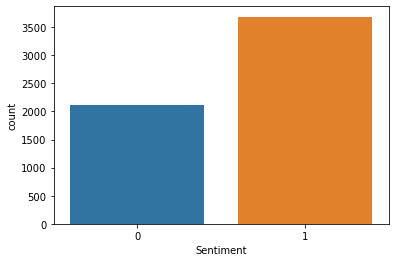

In [6]:
# Unique elements in the 'sentiment' column

sns.countplot(x= 'Sentiment', data=stock_df)

In [7]:
stock_df['Sentiment'].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

# Results
- Looks like we may have an unbalanced dataset which class one have 3685 samples and class 0 have only 2106 samples.

<a id='Eda1'></a>
# EDA 1.
## PERFORM DATA CLEANING (REMOVE PUNCTUATIONS FROM TEXT)

***

In [8]:
# Tell summary of all the different punctuation in dataset
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
# Let's define a function to remove punctuations
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [10]:
# Let's remove punctuations from the dataset 
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)

In [11]:
stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [12]:
# Just checking text examples on index 2
stock_df['Text'][2]

"user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service"

In [13]:
# Checking text without punctuation on index 2
stock_df['Text Without Punctuation'][2]

'user Id be afraid to short AMZN  they are looking like a nearmonopoly in eBooks and infrastructureasaservice'

<a id='Eda2'></a>
# EDA 2.
## PERFORM DATA CLEANING (REMOVE STOPWORDS)

***

In [14]:
# download stopwords library
# Words that are too common and they don't really contribute to any sentiment when training ML models
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harrypatterson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
# Add additional stopwords from nltk (looked throught data)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])

In [16]:
# Remove stopwords and remove short words (less than 3 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [17]:
# apply pre-processing to the text column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [18]:
stock_df.head()

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop..."
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta]
4,OI Over 21.37,1,OI Over 2137,[]


In [19]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [20]:
stock_df['Text Without Punc & Stopwords'][0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

In [21]:
stock_df.tail()

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s..."
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,..."
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri..."
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift..."
5790,"#Sensex, #Nifty climb off day's highs, still u...",1,Sensex Nifty climb off days highs still up 2 K...,"[sensex, nifty, climb, days, highs, still, key..."


<a id='Eda3'></a>
# EDA 3.
## PLOT WORDCLOUD

***

In [22]:
# join the words into one string
# Join all text together then add one space in between
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

In [23]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


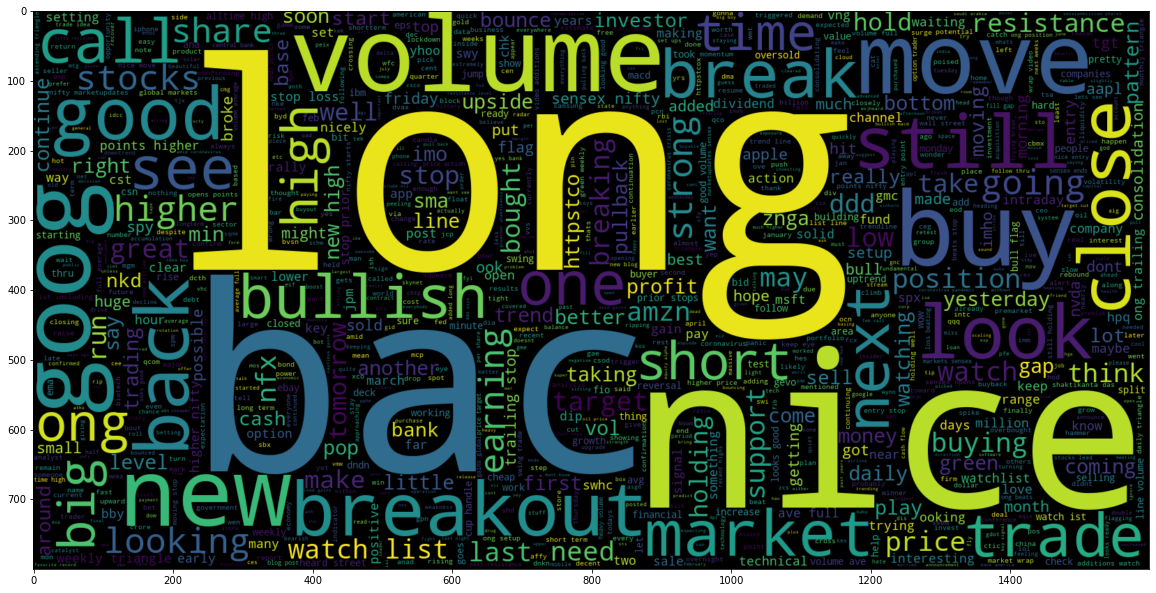

In [24]:
# plot the word cloud for text with positive sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

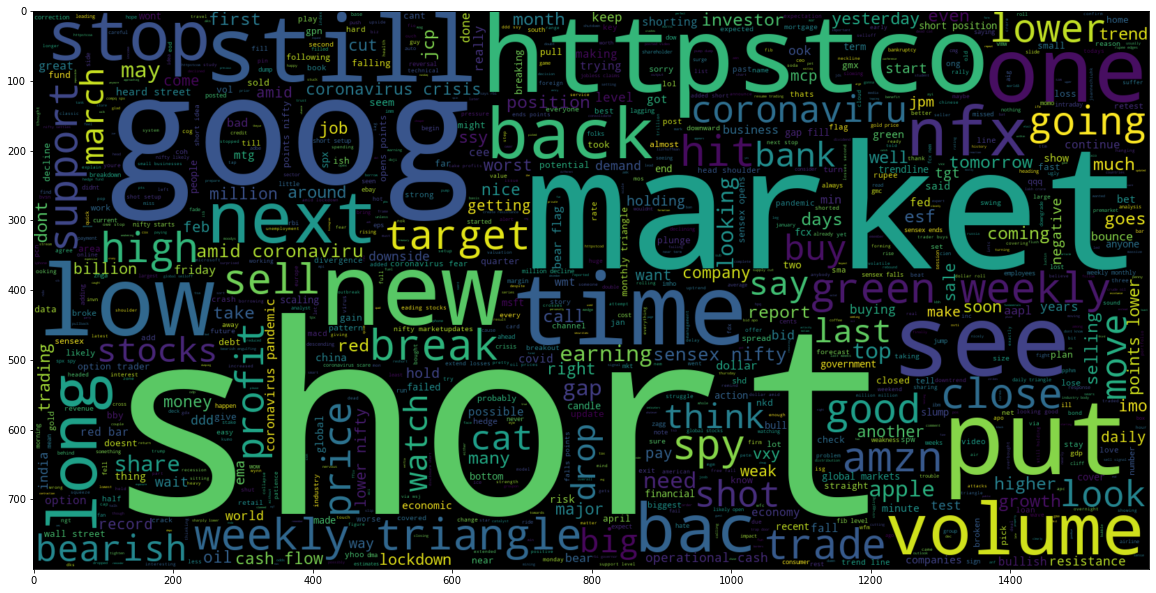

In [26]:
# plot the word cloud for text that have negative sentiment
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000, width = 1600, height = 800 ).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

# Results 

Positive word clouds shows words like long ,buy,nice,volume, move and goog are the most common.
- Long: Expecting the securities price to go up in the future (long securities )
- Buy: People are talking about buying securities

Negative word clouds shows words like short, volume, market
- Short: Maybe the people are expecting the price to go down
- Low: Maybe saying there is a low pricing 

***

<a id='Eda4'></a>
# EDA 4.
## VISUALIZE CLEANED DATASETS

***

In [27]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harrypatterson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# word_tokenize is used to break up a string into words (tokens)
# Just wanted to show an example

print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0])) # used to break up a string into words (tokens)

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [30]:
# Obtain the maximum length of data in the document (count words for each row in column)
# This will be later used when word embeddings are generated

maxlen = -1  # last index
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)   # Break down into a series of tokens
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [32]:
# create list that has every single tweet and have the count of how many words are present 
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 8,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 3,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 12,
 9,
 8,
 1,
 14,
 7,
 11,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 9,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 5,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10

<AxesSubplot:ylabel='Count'>

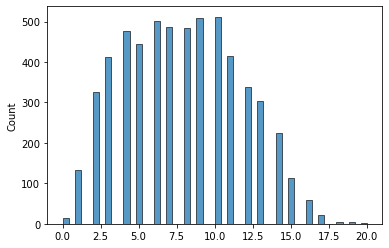

In [35]:
# sns.histplot(data=penguins, x="flipper_length_mm")

sns.histplot(x = tweets_length, bins = 50)

<AxesSubplot:ylabel='Count'>

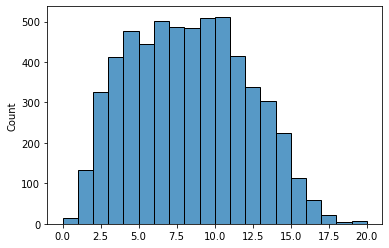

In [37]:
# Plot the distribution for the number of words in a text

sns.histplot(x = tweets_length, bins = 50, binwidth=1)

## Results 

- We have about 510 tweets that contains 10 words (Max)
- Not many tweets contains more than 19 words. 

***

<a id='Token'></a>
## PREPARE THE DATA BY TOKENIZING AND PADDING

- Tokenizer allows us to vectorize text corpus
- Turns each text into a sequence of integers in order to train in a ML or deep learning model. 
***

In [39]:
# Obtain the total words present in the dataset
list_of_words = []  # Placeholder
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:      # j is for every single word in data
        list_of_words.append(j)

        
list_of_words

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'otherwise',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'goog',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'still',
 'much',
 'like',
 'setup',
 'really',
 'worries',
 'everyone',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'every',
 'time',
 'shall',
 'see',
 'soon',
 'bac',
 'spx',
 'jpm',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'chea

In [40]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9268

### TRAIN/TEST SPLIT 

In [42]:
# split the data into test and train 
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)   # 20% allocated for testing 

In [43]:
# Just checking 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4632,)
(4632,)
(1159,)
(1159,)


### Convert text data into numbers
- Create a tokenizer to tokenize the words and create sequences of tokenized words

In [46]:
tokenizer = Tokenizer(num_words = total_words) # specify number of words 
tokenizer.fit_on_texts(X_train)    # Apply fit on text object

# Tokenizing on Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Tokenizing on Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [47]:
# check Tokeinized training data
train_sequences

[[124, 198, 3356, 382, 1],
 [586, 1169, 693, 22, 1014, 469, 62],
 [1403, 1170, 2290, 1015, 1404, 3357, 1016, 3358, 872, 3359, 65, 1171],
 [2291,
  1405,
  498,
  17,
  153,
  759,
  239,
  1017,
  2292,
  587,
  415,
  3360,
  313,
  333,
  2293],
 [189, 102, 131, 1172, 441, 18],
 [539, 56, 3361, 354],
 [66, 33, 221, 2, 1173, 199, 1406, 1747, 3362],
 [872,
  314,
  873,
  1407,
  442,
  760,
  442,
  2294,
  157,
  240,
  10,
  103,
  40,
  874,
  158,
  1408],
 [132, 1748, 1409, 3363, 3364, 260, 761, 875, 1749, 3365],
 [177, 2295, 3366, 98, 289, 67, 261, 540, 91, 206, 29, 231, 115],
 [3367, 232, 29, 290, 1018, 262, 44, 157],
 [116, 541, 1410, 124, 2296, 1750, 1751],
 [41, 30, 21, 3368, 1],
 [74, 1752, 383, 32, 159],
 [1411, 42, 200, 32, 251, 4, 1753, 443],
 [178, 63, 2297, 384, 3369, 588, 3370, 416],
 [3371, 3372, 3373, 2298, 622, 3374],
 [876, 3375],
 [877, 470, 762, 3376, 3377, 694, 3378, 1019, 37, 233, 91],
 [442, 3379, 763, 355, 160, 2299, 199, 119, 291, 3380],
 [41, 30, 21, 2300]

In [48]:
# Tokeinized test data
test_sequences

[[49, 149, 514, 37, 5270, 45, 1351, 32, 429],
 [679, 123, 25, 209, 332, 54, 3237, 274, 770, 1248, 2437],
 [844, 154, 119, 7758, 316, 242, 42, 5, 32, 436, 196],
 [38, 101, 18, 38, 82, 31, 45, 47],
 [1535, 119, 4340, 152, 55, 1430, 464, 806, 428, 32, 262, 44],
 [10, 19, 133, 698],
 [52, 688, 496, 398, 285, 1093, 73, 2140, 375, 119],
 [871, 46, 13],
 [1248, 687, 16],
 [2026, 753, 1083, 1240, 2006, 751, 418],
 [30, 21, 1768, 276, 547, 117],
 [25, 619, 195, 582, 7, 412, 352, 1771, 3130, 386, 2857, 1164, 542],
 [313, 189, 30, 913, 29, 2008, 366, 883, 39],
 [8, 279, 76, 440],
 [7764, 157, 381, 66, 556],
 [78],
 [669, 38, 393, 3, 832, 3],
 [194, 152],
 [20, 460, 40, 15, 27, 57, 657, 260, 399, 22, 444, 135],
 [1634, 128, 906, 219, 404, 95, 259],
 [141, 248, 628, 1405, 1205],
 [11, 1336, 324, 50],
 [8, 2959, 639, 3208, 1086, 53, 40, 51, 1385],
 [961, 1374, 1, 114, 1931, 77, 6971, 77, 290],
 [76, 2194, 2713, 70, 1425, 1172, 81, 393, 4359, 757],
 [17, 106, 22, 1014, 704, 1064, 2530, 1526, 740],
 [

In [49]:
# Show sample text data and tokenized words

print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 5251    [reason, donâ, panic, stocks, plunge, dow, low]
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [586, 1169, 693, 22, 1014, 469, 62]


- Translation: reason (text) = 586 (tokenized)

### PREPARE THE DATA BY ADDING PADDING
- Will transform all tokenized data to be of the same length (size). 
- Example: Data that only consists of 3 tokens will add '0' to make a fixed length.  

In [50]:
# Add padding to training and testing

padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

In [51]:
# check padding to make sure it was successful by visulizing 3 samples
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)  # Use index and add 1

The padded encoding for document: 1  is: [ 124  198 3356  382    1    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [ 586 1169  693   22 1014  469   62    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [1403 1170 2290 1015 1404 3357 1016 3358  872 3359   65 1171    0    0
    0]


In [52]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)  # specify output have 2 dimensions
y_test_cat = to_categorical(y_test, 2)

In [56]:
# Just checking 
print(y_train_cat.shape)
print(y_test_cat.shape)

(4632, 2)
(1159, 2)


In [55]:
y_train_cat

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Having two neurons in the output for training
- Postive sentiment: If one neurons have an output of 1 and the other was zero
- Negative sentiment: if one nerons have an output of 0 and the other was one

***

<a id='MS'></a>
## Model Selection

Long short term memory (LSTM)
- Type of Recurring neural network (RNN)
***

### BUILD A CUSTOM-BASED DEEP NEURAL NETWORK BASED ON LSTM NETWORK TO PERFORM SENTIMENT ANALYSIS

In [59]:
# Sequential Model
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 512)) # Can choose any number

# Bi-Directional RNN and LSTM
model.add(LSTM(256)) # Can choose any number

# Add additoinal Dense layers
model.add(Dense(128, activation = 'relu', ))
model.add(Dropout(0.3))   # Improves the generalization ability of the network (Not to overfit). Dropout 3% of data
model.add(Dense(2,activation = 'softmax')) #output layer (2 outputs). Activation function for classifaction problem 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])   # Compile 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         4745216   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 5,565,826
Trainable params: 5,565,826
Non-trainable params: 0
_________________________________________________________________


In [60]:
# train the model
# Padded_train input data
# y_train_cat is the ouput data
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2) 

Epoch 1/2
116/116 [==============================] - 21s 163ms/step - loss: 0.6156 - acc: 0.6726 - val_loss: 0.5451 - val_acc: 0.7616
Epoch 2/2
116/116 [==============================] - 19s 160ms/step - loss: 0.3363 - acc: 0.8707 - val_loss: 0.5367 - val_acc: 0.7540


In [61]:
# Train the model using different embedding output dimension
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 256))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(2,activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2372608   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 2,800,002
Trainable params: 2,800,002
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2) 

Epoch 1/2
116/116 [==============================] - 17s 119ms/step - loss: 0.5782 - acc: 0.6934 - val_loss: 0.4925 - val_acc: 0.7745
Epoch 2/2
116/116 [==============================] - 12s 104ms/step - loss: 0.2827 - acc: 0.8901 - val_loss: 0.5888 - val_acc: 0.7659


Lowering the ouput dimension and the internal units in the LSTM layer did show an improment with the validation accuracy. 

<a id='Test'></a>
## TEST MODEL PERFORMANCE

In [63]:
# make prediction
pred = model.predict(padded_test)

In [64]:
pred

array([[0.4344116 , 0.5687445 ],
       [0.6753143 , 0.32209688],
       [0.00465703, 0.99525   ],
       ...,
       [0.17199066, 0.8342237 ],
       [0.5092073 , 0.48313534],
       [0.05418158, 0.9458636 ]], dtype=float32)

Predictions have 2 outputs ( round to 0 and 1) 

In [65]:
# make prediction
# Argmax finds the argument that gives the maximum value and used to find the class with the highest probability. 
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [66]:
# Checking 
# Indicates all the different model predictions 
prediction

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,


In [67]:
# list containing original values
# To pring out confusion matrix
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [68]:
# acuracy score on text data

accuracy = accuracy_score(original, prediction)
accuracy

0.7644521138912856

<AxesSubplot:>

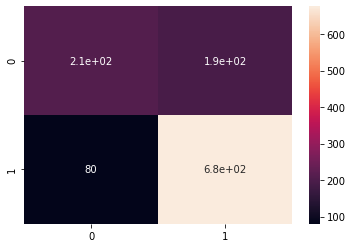

In [69]:
# Plot the confusion matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)

<a id='Conclusion'></a>
## Conclusion

Insights
- Our model performed around 76% on the testing data
- Our model classifies 890(210+680) correct prediction and misclassify 270(190+80) incorrect predictions on testing data
- We would need to try to decrease our false positives because we do not want to base our investments on sentiments that are predicted as positive but labeled as negative. 

Suggestions
- We can try to improve the model by changing the number of units from the LSTM network, Add an additional LSTM model, Change the dropout percentage, Add additional dropout layers, Or play with the hyper parameters 